In [22]:
%matplotlib inline

import os
import glob
import random
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

from tqdm import tqdm

import skimage.io
import skimage.segmentation
import skimage.morphology

import sys
__file__ = 'full_experiment.ipynb'
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))

import utils.dirtools  # utils package should has __init__.py in it
import utils.augmentation
import utils.model_builder
import utils.data_provider
import utils.metrics
import utils.objectives
import utils.evaluation

import keras.backend
import keras.callbacks
import keras.layers
import keras.models
import keras.optimizers
import tensorflow as tf

from config import config_vars

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# build session running on GPU 1
configuration = tf.ConfigProto()
configuration.gpu_options.allow_growth = True
# configuration.gpu_options.visible_device_list = "0, 1"
session = tf.Session(config = configuration)

# apply session
keras.backend.set_session(session)

In [6]:
config_vars["root_directory"] = 'DATA/DNA_FISH/'
experiment_name = '05'

config_vars = utils.dirtools.setup_working_directories(config_vars)
config_vars = utils.dirtools.setup_experiment(config_vars, experiment_name)
os.makedirs(config_vars["normalized_images_dir"], exist_ok=True)
os.makedirs(config_vars["boundary_labels_dir"], exist_ok=True)

config_vars

### PREPROCESS

In [34]:
images = np.zeros((6, 1, 512, 512))
img_list = sorted(glob.glob('DATA/LineageTracking/norm_images/001/*.png'))
for i, im in enumerate(img_list[8:]):
    img = skimage.io.imread(im)
    images[i, 0] = img.squeeze()
    if i == 5:
        break

(6, 1, 512, 512) 0.0 1.0


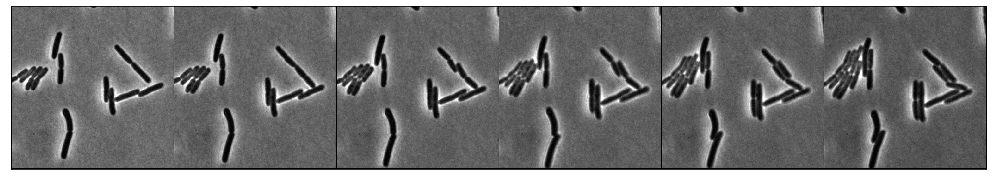

In [35]:
import torch
import torchvision
# show images
images = images/255
print(images.shape, images.min(), images.max())
images = torch.tensor(images)
image = torchvision.utils.make_grid(images, nrow=6)
plt.figure(figsize = (24, 3))
plt.xticks([])
plt.yticks([])
plt.imshow(np.transpose(image.numpy(), (1,2,0)))

# def imshow(img):
# #     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))

# # show images
# print(images.shape)
# imshow(torchvision.utils.make_grid(images, nrow=8))

<a list of 100 Patch objects>

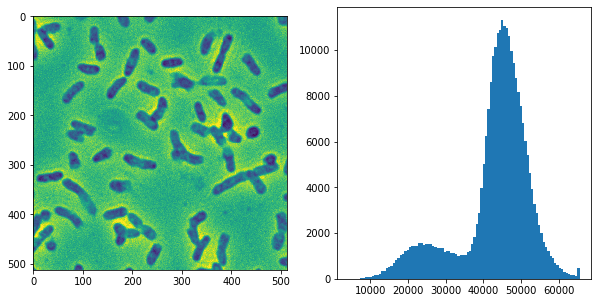

In [7]:
file_list = os.listdir(config_vars["raw_images_dir"])
img = skimage.io.imread(config_vars["raw_images_dir"] + file_list[-1])

figure, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(img)
ax[1].hist(img.flatten(), bins=100)[2]

In [9]:
# normalize images

def normalize_images(config_vars)
    filelist = sorted(os.listdir(config_vars["raw_images_dir"]))
    # run over all raw images
    for filename in tqdm(filelist):
        # load image and its annotation
        orig_img = skimage.io.imread(config_vars["raw_images_dir"] + filename)       
        # normalize to [0,1]
        percentile = 99.9
        high = np.percentile(orig_img, percentile)  # maximum for all image
        low = np.percentile(orig_img, 100-percentile)

        img = np.minimum(high, orig_img)
        img = np.maximum(low, img)

        # gives float64, thus cast to 8 bit later
        img = (img - low) / (high - low) 
        img = skimage.img_as_ubyte(img) 

        skimage.io.imsave(config_vars["normalized_images_dir"] + filename[:-3] + 'png', img)    


  0%|          | 0/77 [00:00<?, ?it/s]/home/lanbowen23/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
100%|██████████| 77/77 [00:04<00:00, 14.58it/s]


In [10]:
# segmentation to boundary

filelist = sorted(os.listdir(config_vars["raw_annotations_dir"]))
filelist = [x for x in filelist if x.endswith('png')]
total_objects = 0

# run over all raw images
for filename in tqdm(filelist):
    # GET ANNOTATION
    annot = skimage.io.imread(config_vars["raw_annotations_dir"] + filename)
    
    # label the annotations nicely to prepare for future filtering operation
    annot = skimage.morphology.label(annot)
    total_objects += len(np.unique(annot)) - 1
    
    # filter small objects, e.g. micronulcei
    annot = skimage.morphology.remove_small_objects(annot, min_size=config_vars["min_nucleus_size"])
    # find boundaries
    boundaries = skimage.segmentation.find_boundaries(annot)
    # make the boundary wider
    for k in range(2, config_vars["boundary_size"], 2):
        boundaries = skimage.morphology.binary_dilation(boundaries)
        
    # 3-CHANNEL BINARY LABEL
    # prepare buffer for binary label
    label_binary = np.zeros((annot.shape + (3,)))  # cannot use dtype=np.uint8 here
    # write binary label
    label_binary[(annot == 0) & (boundaries == 0), 0] = 1  # bg
    label_binary[(annot != 0) & (boundaries == 0), 1] = 1  # cell
    label_binary[boundaries == 1, 2] = 1  # boundary
    # Convert an image to unsigned byte format, with values in [0, 255]
    label_binary = skimage.img_as_ubyte(label_binary)
    # save it - converts image to range from 0 to 255
    skimage.io.imsave(config_vars["boundary_labels_dir"] + filename, label_binary)
    
print("Total objects: ",total_objects)

100%|██████████| 77/77 [00:07<00:00, 10.53it/s]

Total objects:  1132


### TRAIN

#### Set Up Datasets

In [11]:
file_list = os.listdir(config_vars["normalized_images_dir"])
image_list = [x for x in file_list if x.endswith("png")]
len(image_list)

77

In [12]:
# set up train-valid split EVERY-TIME
def create_image_lists(dir_raw_images):
    file_list = os.listdir(dir_raw_images)
    image_list = [x for x in file_list if x.endswith("png")]
    image_list = sorted(image_list)

    image_list_train_aug = []
    image_list_test = []
#     image_list_validation = image_list[63:]

#     image_list_2 = image_list[:63]
#     random.shuffle(image_list_2)
#     image_list_train = image_list_2
    
    image_list_train = []
    image_list_validation = image_list

    return image_list_train, image_list_test, image_list_validation, image_list_train_aug

In [15]:
[list_training, list_test, list_validation, list_training_aug] = create_image_lists(
    config_vars["normalized_images_dir"],
#         config_vars["training_fraction"],
#         config_vars["validation_fraction"]
)

utils.dirtools.write_path_files(config_vars["path_files_training"], list_training)
utils.dirtools.write_path_files(config_vars["path_files_test"], list_test)
utils.dirtools.write_path_files(config_vars["path_files_validation"], list_validation)

In [ ]:
# don't run
# '''use matlab-labelled data to augment''' 
config_vars["path_files_training_aug"] = 'FISH/training_aug.txt'

# modify the write path method to add 'raw_masks/' ahead of the name
utils.dirtools.write_path_files2(config_vars["path_files_training_aug"], list_training_aug)

In [16]:
data_partitions = utils.dirtools.read_data_partitions(config_vars, load_augmented=False)

In [ ]:
# don't run
# append aug filename to training split
with open(config_vars["path_files_training_aug"]) as f:
    data_partitions["training"] += f.read().splitlines()
    
data_partitions["training"]

##### data generator

In [17]:
# setup data-generator
train_gen = utils.data_provider.random_sample_generator(
    config_vars["normalized_images_dir"],
    config_vars["boundary_labels_dir"],
    data_partitions["training"],
    config_vars["batch_size"],
    config_vars["pixel_depth"],
    config_vars["crop_size"],
    config_vars["crop_size"],
    config_vars["rescale_labels"]
)

In [18]:
val_gen = utils.data_provider.single_data_from_images(
     config_vars["normalized_images_dir"],
     config_vars["boundary_labels_dir"],
     data_partitions["validation"],
     config_vars["val_batch_size"],
     config_vars["pixel_depth"],
     config_vars["crop_size"],
     config_vars["crop_size"],
     config_vars["rescale_labels"]
)

#### Traininig Model

In [ ]:
# build model
model = utils.model_builder.get_model_3_class(config_vars["crop_size"], 
                                              config_vars["crop_size"], activation=None)
# model.summary()

#loss = "categorical_crossentropy"
loss = utils.objectives.weighted_crossentropy

metrics = [keras.metrics.categorical_accuracy, 
           utils.metrics.channel_recall(channel=0, name="background_recall"), 
           utils.metrics.channel_precision(channel=0, name="background_precision"),
           utils.metrics.channel_recall(channel=1, name="interior_recall"), 
           utils.metrics.channel_precision(channel=1, name="interior_precision"),
           utils.metrics.channel_recall(channel=2, name="boundary_recall"), 
           utils.metrics.channel_precision(channel=2, name="boundary_precision"),
          ]

optimizer = keras.optimizers.RMSprop(lr=config_vars["learning_rate"])

model.compile(loss=loss, metrics=metrics, optimizer=optimizer)

In [ ]:
# Callbacks
log_folder = 'logs/'
csv = keras.callbacks.CSVLogger(filename=config_vars["csv_log_file"])
tboard = keras.callbacks.TensorBoard(log_dir=log_folder + experiment_name, 
                                      histogram_freq=0, 
                                      batch_size=32, 
                                      write_graph=True, 
                                      write_grads=False, write_images=True,
                                      update_freq='epoch')
# add ModelCheckpoints
# monitor val-loss
weights_filename = log_folder + experiment_name + '/model-{epoch:02d}-{val_loss:.2f}.h5'
modelckp = keras.callbacks.ModelCheckpoint(weights_filename, verbose=1, period=1,
                                     save_best_only=True, save_weights_only=True)

# min_delta: threshold for measuring the new optimum,
#       to only focus on significant changes.
# cooldown: number of epochs to wait before resuming
#       normal operation after lr has been reduced.
reducelr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, 
                                             verbose=1, mode='min', min_lr=1e-7, 
                                             cooldown=10, min_delta=1e-4)
# min_lr could be smaller

callbacks = [csv, tboard, modelckp, reducelr]

In [ ]:
# load weights
weight_h5_file = 'DATA/FISH/experiments/03/model.hdf5'
if os.path.isfile(weight_h5_file):
    try:
        model.load_weights(weight_h5_file)
    except:
        print('the model {} can not  be loaded'.format(weight_h5_file))
        pass

In [ ]:
config_vars["epochs"] = 200

In [ ]:
# TRAIN
statistics = model.fit_generator(
    generator=train_gen,
    steps_per_epoch=config_vars["steps_per_epoch"],
    epochs=config_vars["epochs"],
    validation_data=val_gen,
    validation_steps=int(len(data_partitions["validation"])/config_vars["val_batch_size"]),
    callbacks=callbacks,
    verbose = 1
)
print('Done! :)')

# save one weight at the end of the training
model.save_weights(config_vars["model_file"])

### PREDICT

In [19]:
config_vars['model_file'] = 'model.hdf5'

In [23]:
partition = "validation"
image_names = [os.path.join(config_vars["normalized_images_dir"], f) \
               for f in data_partitions[partition]]

imagebuffer = skimage.io.imread_collection(image_names)
images = imagebuffer.concatenate()

dim1 = images.shape[1]
dim2 = images.shape[2]
images = images.reshape((-1, dim1, dim2, 1))
# preprocess (assuming images are encoded as 8-bits in the preprocessing step)
images = images / 255

# build model and load weights
model = utils.model_builder.get_model_3_class(dim1, dim2)
model.load_weights(config_vars["model_file"])

# Normal prediction time
predictions = model.predict(images, batch_size=1)

In [25]:
def empty_dir(folder):
    print('empty directory: ', folder)
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            #elif os.path.isdir(file_path): shutil.rmtree(file_path)
        except Exception as e:
            print(e)

In [26]:
empty_dir(config_vars["probmap_out_dir"])
empty_dir(config_vars["labels_out_dir"])

empty directory:  DATA/DNA_FISH/experiments/05/out/prob/
empty directory:  DATA/DNA_FISH/experiments/05/out/segm/


Lossy conversion from float32 to uint8. Range [0.0, 12.532366752624512]. Convert image to uint8 prior to saving to suppress this warning.


0000.png


Lossy conversion from int64 to uint8. Range [0, 44]. Convert image to uint8 prior to saving to suppress this warning.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


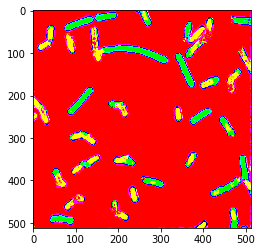

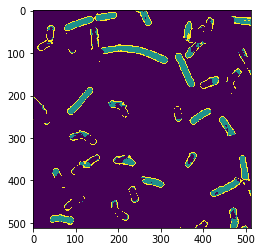

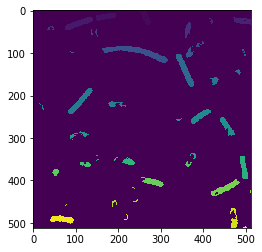

Lossy conversion from float32 to uint8. Range [0.0, 12.795540809631348]. Convert image to uint8 prior to saving to suppress this warning.


0001.png


Lossy conversion from int64 to uint8. Range [0, 35]. Convert image to uint8 prior to saving to suppress this warning.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


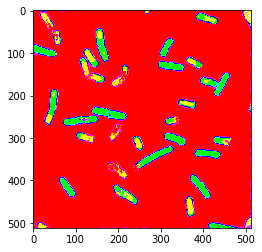

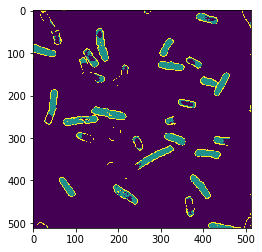

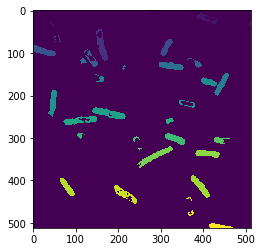

Lossy conversion from float32 to uint8. Range [0.0, 13.069046974182129]. Convert image to uint8 prior to saving to suppress this warning.


0002.png


Lossy conversion from int64 to uint8. Range [0, 42]. Convert image to uint8 prior to saving to suppress this warning.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


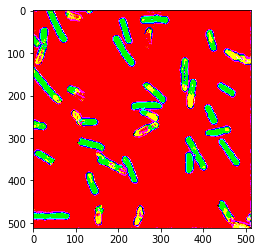

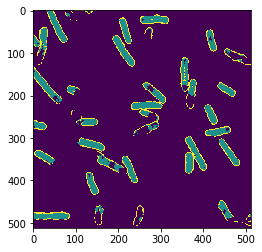

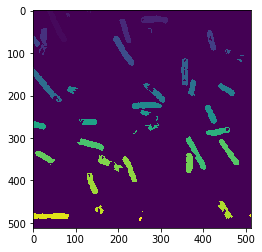

Lossy conversion from float32 to uint8. Range [0.0, 13.103074073791504]. Convert image to uint8 prior to saving to suppress this warning.


0003.png


Lossy conversion from int64 to uint8. Range [0, 41]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 13.071000099182129]. Convert image to uint8 prior to saving to suppress this warning.


0004.png


Lossy conversion from int64 to uint8. Range [0, 35]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 13.565424919128418]. Convert image to uint8 prior to saving to suppress this warning.


0005.png


Lossy conversion from int64 to uint8. Range [0, 38]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 12.918089866638184]. Convert image to uint8 prior to saving to suppress this warning.


0006.png


Lossy conversion from int64 to uint8. Range [0, 31]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 12.900230407714844]. Convert image to uint8 prior to saving to suppress this warning.


0007.png


Lossy conversion from int64 to uint8. Range [0, 43]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 13.563714981079102]. Convert image to uint8 prior to saving to suppress this warning.


0008.png


Lossy conversion from int64 to uint8. Range [0, 39]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 16.62278938293457]. Convert image to uint8 prior to saving to suppress this warning.


0009.png


Lossy conversion from int64 to uint8. Range [0, 44]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 12.969606399536133]. Convert image to uint8 prior to saving to suppress this warning.


0010.png


Lossy conversion from int64 to uint8. Range [0, 50]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 12.598560333251953]. Convert image to uint8 prior to saving to suppress this warning.


0011.png


Lossy conversion from int64 to uint8. Range [0, 34]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 12.796032905578613]. Convert image to uint8 prior to saving to suppress this warning.


0012.png


Lossy conversion from int64 to uint8. Range [0, 50]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 13.060137748718262]. Convert image to uint8 prior to saving to suppress this warning.


0013.png


Lossy conversion from int64 to uint8. Range [0, 45]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 12.576109886169434]. Convert image to uint8 prior to saving to suppress this warning.


0014.png


Lossy conversion from int64 to uint8. Range [0, 37]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 12.846631050109863]. Convert image to uint8 prior to saving to suppress this warning.


0015.png


Lossy conversion from int64 to uint8. Range [0, 48]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 13.073201179504395]. Convert image to uint8 prior to saving to suppress this warning.


0016.png


Lossy conversion from int64 to uint8. Range [0, 38]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 12.82923412322998]. Convert image to uint8 prior to saving to suppress this warning.


0017.png


Lossy conversion from int64 to uint8. Range [0, 33]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 12.891968727111816]. Convert image to uint8 prior to saving to suppress this warning.


0018.png


Lossy conversion from int64 to uint8. Range [0, 46]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 12.988083839416504]. Convert image to uint8 prior to saving to suppress this warning.


0019.png


Lossy conversion from int64 to uint8. Range [0, 24]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 13.074454307556152]. Convert image to uint8 prior to saving to suppress this warning.


0020.png


Lossy conversion from int64 to uint8. Range [0, 17]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 12.675467491149902]. Convert image to uint8 prior to saving to suppress this warning.


0021.png


Lossy conversion from int64 to uint8. Range [0, 29]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 13.750091552734375]. Convert image to uint8 prior to saving to suppress this warning.


0022.png


Lossy conversion from int64 to uint8. Range [0, 44]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 13.991316795349121]. Convert image to uint8 prior to saving to suppress this warning.


0023.png


Lossy conversion from int64 to uint8. Range [0, 41]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 13.249747276306152]. Convert image to uint8 prior to saving to suppress this warning.


0024.png


Lossy conversion from int64 to uint8. Range [0, 44]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 13.433411598205566]. Convert image to uint8 prior to saving to suppress this warning.


0025.png


Lossy conversion from int64 to uint8. Range [0, 28]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 13.589972496032715]. Convert image to uint8 prior to saving to suppress this warning.


0026.png


Lossy conversion from int64 to uint8. Range [0, 50]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 18.196517944335938]. Convert image to uint8 prior to saving to suppress this warning.


0027.png


Lossy conversion from int64 to uint8. Range [0, 20]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 16.39415168762207]. Convert image to uint8 prior to saving to suppress this warning.


0028.png


Lossy conversion from int64 to uint8. Range [0, 47]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 14.763666152954102]. Convert image to uint8 prior to saving to suppress this warning.


0029.png


Lossy conversion from int64 to uint8. Range [0, 17]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 13.95260238647461]. Convert image to uint8 prior to saving to suppress this warning.


0030.png


Lossy conversion from int64 to uint8. Range [0, 43]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 14.634978294372559]. Convert image to uint8 prior to saving to suppress this warning.


0031.png


Lossy conversion from int64 to uint8. Range [0, 22]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 13.894206047058105]. Convert image to uint8 prior to saving to suppress this warning.


0032.png


Lossy conversion from int64 to uint8. Range [0, 35]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 13.544934272766113]. Convert image to uint8 prior to saving to suppress this warning.


0033.png


Lossy conversion from int64 to uint8. Range [0, 26]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 15.470338821411133]. Convert image to uint8 prior to saving to suppress this warning.


0034.png


Lossy conversion from int64 to uint8. Range [0, 29]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 15.572684288024902]. Convert image to uint8 prior to saving to suppress this warning.


0035.png


Lossy conversion from int64 to uint8. Range [0, 26]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 14.717638969421387]. Convert image to uint8 prior to saving to suppress this warning.


0036.png


Lossy conversion from int64 to uint8. Range [0, 10]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 16.713794708251953]. Convert image to uint8 prior to saving to suppress this warning.


0037.png


Lossy conversion from int64 to uint8. Range [0, 11]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 15.098674774169922]. Convert image to uint8 prior to saving to suppress this warning.


0038.png


Lossy conversion from int64 to uint8. Range [0, 11]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 13.39026165008545]. Convert image to uint8 prior to saving to suppress this warning.


0039.png


Lossy conversion from int64 to uint8. Range [0, 26]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 19.122852325439453]. Convert image to uint8 prior to saving to suppress this warning.


0040.png


Lossy conversion from int64 to uint8. Range [0, 21]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 14.661177635192871]. Convert image to uint8 prior to saving to suppress this warning.


0041.png


Lossy conversion from int64 to uint8. Range [0, 41]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 14.271103858947754]. Convert image to uint8 prior to saving to suppress this warning.


0042.png


Lossy conversion from int64 to uint8. Range [0, 10]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 14.268258094787598]. Convert image to uint8 prior to saving to suppress this warning.


0043.png


Lossy conversion from int64 to uint8. Range [0, 15]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 16.312652587890625]. Convert image to uint8 prior to saving to suppress this warning.


0044.png


Lossy conversion from int64 to uint8. Range [0, 16]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 14.68423843383789]. Convert image to uint8 prior to saving to suppress this warning.


0045.png


Lossy conversion from int64 to uint8. Range [0, 16]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 15.717175483703613]. Convert image to uint8 prior to saving to suppress this warning.


0046.png


Lossy conversion from int64 to uint8. Range [0, 13]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 13.686453819274902]. Convert image to uint8 prior to saving to suppress this warning.


0047.png


Lossy conversion from int64 to uint8. Range [0, 12]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 13.049281120300293]. Convert image to uint8 prior to saving to suppress this warning.


0048.png


Lossy conversion from int64 to uint8. Range [0, 17]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 14.069231986999512]. Convert image to uint8 prior to saving to suppress this warning.


0049.png


Lossy conversion from int64 to uint8. Range [0, 13]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 13.146742820739746]. Convert image to uint8 prior to saving to suppress this warning.


0050.png


Lossy conversion from int64 to uint8. Range [0, 14]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 13.478154182434082]. Convert image to uint8 prior to saving to suppress this warning.


0051.png


Lossy conversion from int64 to uint8. Range [0, 16]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 13.613714218139648]. Convert image to uint8 prior to saving to suppress this warning.


0052.png


Lossy conversion from int64 to uint8. Range [0, 25]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 13.429624557495117]. Convert image to uint8 prior to saving to suppress this warning.


0053.png


Lossy conversion from int64 to uint8. Range [0, 17]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 12.842971801757812]. Convert image to uint8 prior to saving to suppress this warning.


0054.png


Lossy conversion from int64 to uint8. Range [0, 14]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 13.655863761901855]. Convert image to uint8 prior to saving to suppress this warning.


0055.png


Lossy conversion from int64 to uint8. Range [0, 18]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 13.182965278625488]. Convert image to uint8 prior to saving to suppress this warning.


0056.png


Lossy conversion from int64 to uint8. Range [0, 15]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 14.618890762329102]. Convert image to uint8 prior to saving to suppress this warning.


0057.png


Lossy conversion from int64 to uint8. Range [0, 19]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 13.824933052062988]. Convert image to uint8 prior to saving to suppress this warning.


0058.png


Lossy conversion from int64 to uint8. Range [0, 16]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 12.462239265441895]. Convert image to uint8 prior to saving to suppress this warning.


0059.png


Lossy conversion from int64 to uint8. Range [0, 17]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 14.5051908493042]. Convert image to uint8 prior to saving to suppress this warning.


0060.png


Lossy conversion from int64 to uint8. Range [0, 17]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 13.769481658935547]. Convert image to uint8 prior to saving to suppress this warning.


0061.png


Lossy conversion from int64 to uint8. Range [0, 11]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 13.70736026763916]. Convert image to uint8 prior to saving to suppress this warning.


0062.png


Lossy conversion from int64 to uint8. Range [0, 10]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 13.167756080627441]. Convert image to uint8 prior to saving to suppress this warning.


0063.png


Lossy conversion from int64 to uint8. Range [0, 15]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 14.19621467590332]. Convert image to uint8 prior to saving to suppress this warning.


0064.png


Lossy conversion from int64 to uint8. Range [0, 6]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 14.314078330993652]. Convert image to uint8 prior to saving to suppress this warning.


0065.png


Lossy conversion from int64 to uint8. Range [0, 19]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 14.292075157165527]. Convert image to uint8 prior to saving to suppress this warning.


0066.png


Lossy conversion from int64 to uint8. Range [0, 15]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 15.378190040588379]. Convert image to uint8 prior to saving to suppress this warning.


0067.png


Lossy conversion from int64 to uint8. Range [0, 17]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 14.730196952819824]. Convert image to uint8 prior to saving to suppress this warning.


0068.png


Lossy conversion from int64 to uint8. Range [0, 20]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 13.763453483581543]. Convert image to uint8 prior to saving to suppress this warning.


0069.png


Lossy conversion from int64 to uint8. Range [0, 24]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 13.730408668518066]. Convert image to uint8 prior to saving to suppress this warning.


0070.png


Lossy conversion from int64 to uint8. Range [0, 21]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 12.68848705291748]. Convert image to uint8 prior to saving to suppress this warning.


0071.png


Lossy conversion from int64 to uint8. Range [0, 14]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 11.815900802612305]. Convert image to uint8 prior to saving to suppress this warning.


0072.png


Lossy conversion from int64 to uint8. Range [0, 18]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 13.105134010314941]. Convert image to uint8 prior to saving to suppress this warning.


0073.png


Lossy conversion from int64 to uint8. Range [0, 22]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 13.858256340026855]. Convert image to uint8 prior to saving to suppress this warning.


0074.png


Lossy conversion from int64 to uint8. Range [0, 14]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 13.418680191040039]. Convert image to uint8 prior to saving to suppress this warning.


0075.png


Lossy conversion from int64 to uint8. Range [0, 15]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 13.091283798217773]. Convert image to uint8 prior to saving to suppress this warning.


0076.png


Lossy conversion from int64 to uint8. Range [0, 17]. Convert image to uint8 prior to saving to suppress this warning.


In [28]:
# boundary to segmentation

for i in range(len(images)):
    filename = imagebuffer.files[i]
    filename = os.path.basename(filename)
    print(filename)
    
    probmap = predictions[i].squeeze()
    skimage.io.imsave(config_vars["probmap_out_dir"] + filename, probmap)
    
    pred = utils.metrics.probmap_to_pred(probmap, config_vars["boundary_boost_factor"])
    label = utils.metrics.pred_to_label(pred, config_vars["cell_min_size"])
    skimage.io.imsave(config_vars["labels_out_dir"] + filename, label)
    
    if (i < 3):
        f, ax = plt.subplots(1,3,figsize=(12,4))
        ax[0].imshow(probmap)
        ax[1].imshow(pred)
        ax[2].imshow(label)
        for a in ax:
            a.set_xticks([])
            a.set_yticks([])
        plt.show()
#         plt.imshow(probmap)
#         plt.show()
#         plt.imshow(pred)
#         plt.show()
#         plt.imshow(label)
#         plt.show() 


#### Remove Border Nuclei

In [29]:
def remove(pred_label, cb):
    # how to use filter to constrain not removing big nucleus
    out = pred_label.copy()
    out_f = out.ravel()  # flatten out
    component_sizes = np.bincount(out_f)
    cb_ = cb
#     cb_ = []
#     for c in cb:
#         if component_sizes[c] < 400:  # 357 this should be larger???
#             cb_.append(c)
            
    for i in range(out.shape[0]):
        for j in range(out.shape[1]):
            for c in cb_:
                if out[i, j] == c:
                    out[i, j] = 0
    
    return out

def remove_border(pred_label):
    # find the classes of the partial nuclei which located on the border
    # traverse the border
    cb = set()
    for i in range(512):
        if pred_label[i, 0] != 0:
            cb.add(pred_label[i, 0])
        if pred_label[0, i] != 0:
            cb.add(pred_label[0, i])
        if pred_label[i, 511] != 0:
            cb.add(pred_label[i, 511])
        if pred_label[511, i] != 0:
            cb.add(pred_label[511, i])
    
    # change these classes to 0 as background
    # maybe I should add a constrain about not filtering the big cell
    return remove(pred_label, cb)

In [30]:
def difference(raw_label, pred_label):
    ground_truth = raw_label.copy()
    prediction = pred_label.copy()
    IOU = utils.evaluation.intersection_over_union(ground_truth, prediction)
    diff = np.zeros(ground_truth.shape + (3,))  # become 3 channels
    A = ground_truth.copy()
    B = prediction.copy()
    A[A > 0] = 1
    B[B > 0] = 1
    D = A - B
    #diff[D > 0,:2] = 1
    #diff[D < 0,1:] = 1
    
    # Object-level errors
    C = IOU.copy()
    threshold = 0.5  # if set to 0.8, more misses will appear, but 0.5 no miss
    C[C >= threshold] = 1
    C[C < threshold] = 0
    missed = np.where(np.sum(C, axis = 1) == 0)[0]  # for original cell, none predict cell match 
    extra = np.where(np.sum(C, axis = 0) == 0)[0]  # for predict cell, none original cell match

    for m in missed:
        diff[ground_truth == m + 1, 0] = 1
    for e in extra:
        diff[prediction == e + 1, 2] = 1
        
    return diff, str(len(missed)), str(len(extra))

In [31]:
def compare(img_name):
    ori_img_filename = os.path.join(config_vars["normalized_images_dir"], img_name)
    original_image = skimage.io.imread(ori_img_filename)
    annot_filename = os.path.join(config_vars["raw_annotations_dir"], img_name)
    raw_label = skimage.io.imread(annot_filename)
    pred_label_filename = os.path.join(config_vars["labels_out_dir"], img_name)
    pred_label = skimage.io.imread(pred_label_filename)

    ppred_label = remove_border(pred_label)  # after post-processed
    
    raw_label = skimage.morphology.label(raw_label)
    raw_label = skimage.segmentation.relabel_sequential(raw_label)[0] #[30:-30,30:-30])[0]
    
    struct = skimage.morphology.square(config_vars["object_dilation"])
    pred_label = skimage.morphology.dilation(pred_label, struct)
    pred_label = skimage.segmentation.relabel_sequential(pred_label)[0] #[30:-30,30:-30])[0]
    
    ppred_label = skimage.morphology.dilation(ppred_label, struct)
    ppred_label = skimage.segmentation.relabel_sequential(ppred_label)[0] #[30:-30,30:-30])[0]
    
    diff, missed, extra = difference(raw_label, pred_label)
    diff2, missed2, extra2 = difference(raw_label, ppred_label)
        
    # make graph easier to look
    inc = lambda x: x if x == 0 else x + 100
    inc = np.vectorize(inc)
    raw_label = inc(raw_label)
    pred_label = inc(pred_label)
    ppred_label = inc(ppred_label)
        
    fig, ax = plt.subplots(2, 4, figsize=(14,5))
    fig.suptitle(img_name)
    ax[0][0].set_title("Original image")
    ax[0][0].imshow(original_image)
    ax[0][1].set_title("Raw label: " + str(len(np.unique(raw_label))) + " objects")
    ax[0][1].imshow(raw_label)
    ax[0][2].set_title("Our predicted label: " + str(len(np.unique(pred_label))) + " objects")
    ax[0][2].imshow(pred_label)
    ax[0][3].set_title("Difference: " + missed + ' missed, ' + extra + ' extra')
    ax[0][3].imshow(diff)
    
#     ax[1][0].set_title("Original image")
    ax[1][0].imshow(original_image)
#     ax[1][1].set_title("Raw label: " + str(len(np.unique(raw_label))) + " objects")
    ax[1][1].imshow(raw_label)
    ax[1][2].imshow(ppred_label)
    ax[1][2].set_title("After post-processed border: " + str(len(np.unique(ppred_label))) + " objects", y=1.08)
    ax[1][3].imshow(diff2)
    ax[1][3].set_title("Difference: " + missed2 + ' missed, ' + extra2 + ' extra', y=1.08)
    plt.tight_layout()  # make title not overlap

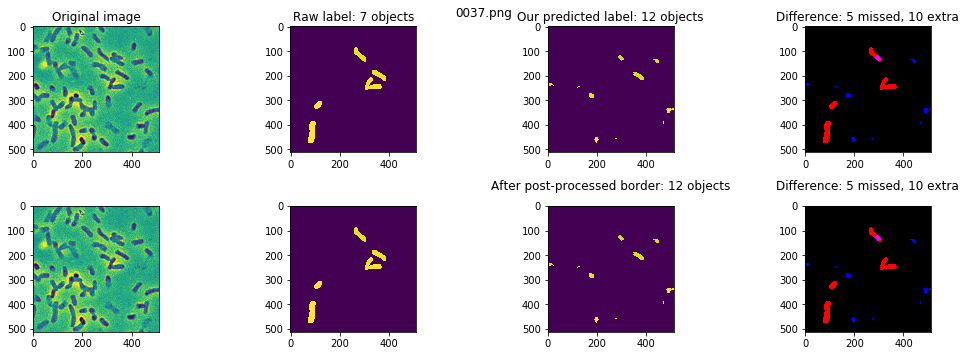

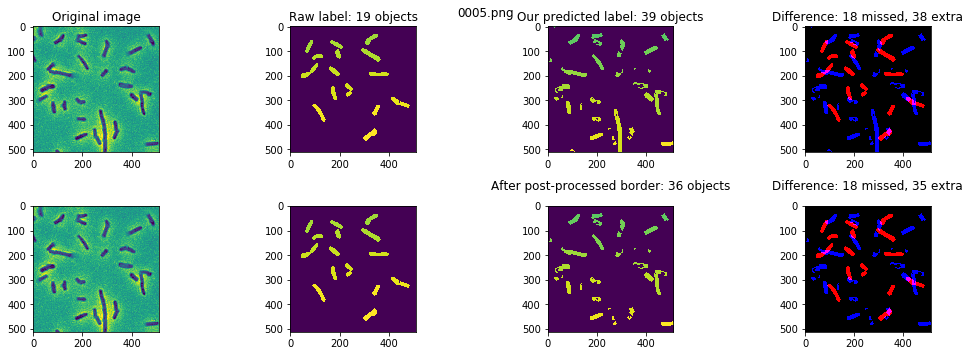

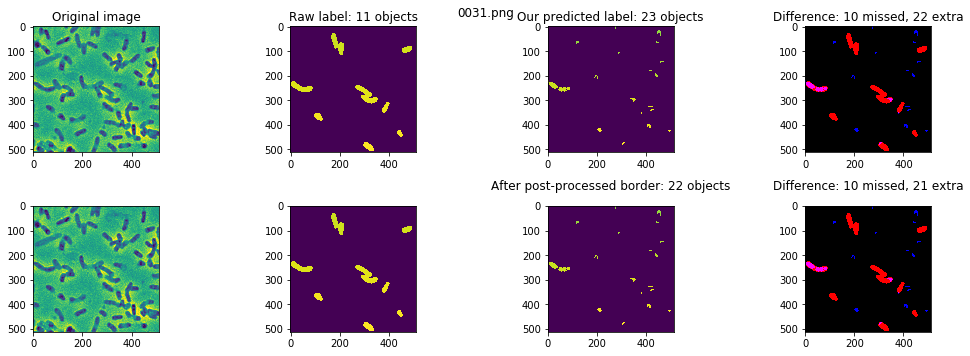

In [33]:
# here 77 and 3 means randomly display 3 images from total 77 images
for i in np.random.randint(77, size = 3):
    img = "{:04}".format(i) + ".png"
    compare(img)

### Evaluation

In [ ]:
# Display prediction along with ground truth to visualize errors

def show(ground_truth, prediction, threshold=0.5, image_name="N"):
    # Compute Intersection over Union
    IOU = utils.evaluation.intersection_over_union(ground_truth, prediction)

    # Create diff map
    diff = np.zeros(ground_truth.shape + (3,))  # become 3 channels
    A = ground_truth.copy()
    B = prediction.copy()
    A[A > 0] = 1
    B[B > 0] = 1
    D = A - B
    
    # Object-level errors
    C = IOU.copy()
    C[C >= threshold] = 1
    C[C < threshold] = 0
    missed = np.where(np.sum(C, axis=1) == 0)[0]
    extra = np.where(np.sum(C, axis=0) == 0)[0]

    for m in missed:
        diff[ground_truth == m+1, 0] = 1
    for e in extra:
        diff[prediction == e+1, 2] = 1
    
    # Display figures
    fig, ax = plt.subplots(1, 4, figsize=(18,6))
    ax[0].imshow(ground_truth)
    ax[0].set_title("True objects: " + str(len(np.unique(ground_truth))))
    ax[1].imshow(diff)
    ax[1].set_title("Segmentation errors: " + str(len(missed)))
    ax[2].imshow(prediction)
    ax[2].set_title("Predicted objects:" + str(len(np.unique(prediction))))
    ax[3].imshow(IOU)
    ax[3].set_title(image_name)

In [ ]:
all_images = data_partitions[partition]  # validation

results = pd.DataFrame(columns=["Image", "Threshold", "F1", "Jaccard", "TP", "FP", "FN"])
false_negatives = pd.DataFrame(columns=["False_Negative", "Area"])
splits_merges = pd.DataFrame(columns=["Image_Name", "Merges", "Splits"])

for image_name in all_images:
    # Load ground truth data
    img_filename = os.path.join(config_vars["raw_annotations_dir"], image_name)
    ground_truth = skimage.io.imread(img_filename)
    if len(ground_truth.shape) == 3:
        ground_truth = ground_truth[:,:,0]
    
    # Transform to label matrix
    ground_truth = skimage.morphology.label(ground_truth)
    
    # Load predictions
    pred_filename = os.path.join(config_vars["labels_out_dir"], image_name)
    prediction = skimage.io.imread(pred_filename)
    
    # Apply object dilation
    if config_vars["object_dilation"] > 0:
        struct = skimage.morphology.square(config_vars["object_dilation"])
        prediction = skimage.morphology.dilation(prediction, struct)
    elif config_vars["object_dilation"] < 0:
        struct = skimage.morphology.square(-config_vars["object_dilation"])
        prediction = skimage.morphology.erosion(prediction, struct)
        
    # Relabel objects (cut margin of 30 pixels to make a fair comparison with DeepCell)
    ground_truth = skimage.segmentation.relabel_sequential(ground_truth)[0] #[30:-30,30:-30])[0]
    prediction = skimage.segmentation.relabel_sequential(prediction)[0] #[30:-30,30:-30])[0]
    
    # Compute evaluation metrics
    # Add result into pd dataframe one by one
    results = utils.evaluation.compute_af1_results(
        ground_truth, 
        prediction, 
        results, 
        image_name
    )
    
    false_negatives = utils.evaluation.get_false_negatives(
        ground_truth, 
        prediction, 
        false_negatives, 
        image_name
    )
    
    splits_merges = utils.evaluation.get_splits_and_merges(
        ground_truth, 
        prediction, 
        splits_merges, 
        image_name
    )
    
    # Display an example image
    if image_name == all_images[0]:
        show(ground_truth, prediction, image_name=image_name)

In [ ]:
average_performance = results.groupby("Threshold").mean().reset_index()
average_performance

In [ ]:
R = results.groupby("Image").mean().reset_index()
R.sort_values(by="F1", ascending=False)

In [ ]:
g = sb.jointplot(data=R[R["F1"] > 0.4], x="Jaccard", y="F1")

In [ ]:
# Plot accuracy results

sb.regplot(data=average_performance, x="Threshold", y="F1", order=3, ci=None)

In [ ]:
# Compute and print Average F1

average_F1_score = average_performance["F1"].mean()
jaccard_index = average_performance["Jaccard"].mean()
print("Average F1 score:", average_F1_score)
print("Jaccard index:", jaccard_index)

# Summarize False Negatives by area

false_negatives = false_negatives[false_negatives["False_Negative"] == 1]

false_negatives.groupby(
    pd.cut(
        false_negatives["Area"], 
        [0, 250, 625, 900, 10000], # Area intervals
        labels = ["Tiny nuclei","Small nuclei","Normal nuclei","Large nuclei"],
    )
)["False_Negative"].sum()

# Summarize splits and merges

print("Splits:", np.sum(splits_merges["Splits"]))
print("Merges:", np.sum(splits_merges["Merges"]))

# Report false positives

print("Extra objects (false postives): ", 
      results[results["Threshold"].round(3) == 0.7].sum()["FP"])

### PRINT Results

In [ ]:
images_dirs = ['DATA/DNA_FISH/norm_images/',
              'DATA/IF_images/norm_images/',
              'DATA/Lineage_Tracking_ZY/norm_images/',
              'DATA/Lineage_Tracking_KZ/norm_images/']

labels_dirs = ['DATA/DNA_FISH/experiments/04/out/segm/',
              'DATA/IF_images/experiments/04/out/segm/',
              'DATA/Lineage_Tracking_ZY/experiments/04/out/segm/',
              'DATA/Lineage_Tracking_KZ/experiments/04/out/segm/']

In [ ]:
def difference(raw_label, pred_label):
    ground_truth = raw_label.copy()
    prediction = pred_label.copy()
    IOU = utils.evaluation.intersection_over_union(ground_truth, prediction)
    diff = np.zeros(ground_truth.shape + (3,))  # become 3 channels
    A = ground_truth.copy()
    B = prediction.copy()
    A[A > 0] = 1
    B[B > 0] = 1
    D = A - B
    #diff[D > 0,:2] = 1
    #diff[D < 0,1:] = 1
    
    # Object-level errors
    C = IOU.copy()
    threshold = 0.5  # if set to 0.8, more misses will appear, but 0.5 no miss
    C[C >= threshold] = 1
    C[C < threshold] = 0
    missed = np.where(np.sum(C, axis = 1) == 0)[0]  # for original cell, none predict cell match 
    extra = np.where(np.sum(C, axis = 0) == 0)[0]  # for predict cell, none original cell match

    for m in missed:
        diff[ground_truth == m + 1, 0] = 1
    for e in extra:
        diff[prediction == e + 1, 2] = 1
        
    return diff, str(len(missed)), str(len(extra))

In [ ]:
def compare(img_name):
    original_images = []
    pred_labels = []
    for i in range(4):
        ori_img_filename = os.path.join(images_dirs[i], img_name)
        original_image = skimage.io.imread(ori_img_filename)
    
        pred_label_filename = os.path.join(labels_dirs[i], img_name)
        pred_label = skimage.io.imread(pred_label_filename)
        
        struct = skimage.morphology.square(3)
        pred_label = skimage.morphology.dilation(pred_label, struct)
        pred_label = skimage.segmentation.relabel_sequential(pred_label)[0] #[30:-30,30:-30])[0]
            
        # make graph easier to look
        inc = lambda x: x if x == 0 else x + 100
        inc = np.vectorize(inc)
        pred_label = inc(pred_label)
        
        original_images.append(original_image)
        pred_labels.append(pred_label)
        
    fig, ax = plt.subplots(2, 4, figsize=(20,10))
    fig.suptitle(img_name)
    ax[0][0].set_title("DNA_FISH")
    ax[0][0].imshow(original_images[0])
    ax[0][1].set_title("IF_images")
    ax[0][1].imshow(original_images[1])
    ax[0][2].set_title("Linear_Tracking_zy")
    ax[0][2].imshow(original_images[2])
    ax[0][3].set_title("Linear_Tracking_kz")
    ax[0][3].imshow(original_images[3])
    
#     ax[1][0].set_title("DNA_FISH")
    ax[1][0].imshow(pred_labels[0])
#     ax[1][1].set_title("IF_images")
    ax[1][1].imshow(pred_labels[1])
#     ax[1][2].set_title("Linear_Tracking_zy")
    ax[1][2].imshow(pred_labels[2])
#     ax[1][3].set_title("Linear_Tracking_kz")
    ax[1][3].imshow(pred_labels[3])


    # plt.figure(figsize=(6,6))
    # plt.imshow(original_image)  #, cmap="nipy_spectral")
    # plt.show()

In [ ]:
for i in np.random.randint(74, size = 20):
    img = "{:04}".format(i) + ".png"
    compare(img)